In [147]:
import pandas as pd
import numpy as np, pandas as pd
from scipy import stats
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import geopandas as gpd
from geopandas import GeoDataFrame
import warnings
import hashlib
import h3
from h3 import h3
import json
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Introduction 
In this notebook, we will work with a dataset of Chicago's community areas. Our goal is to create hexagons based on this dataset. We will develop two functions: `hexagonize_geodataframe`, which generates hexagons of a specified size, and `assign_hexagons_to_areas`, which assigns the generated hexagons back to the community areas through a spatial join.

In [148]:
# Read the GeoJSON file of the Chicago Community Areas
geojson_file = "../Datasets/Boundaries - Community Areas.geojson"
gdf = gpd.read_file(geojson_file)
gdf.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


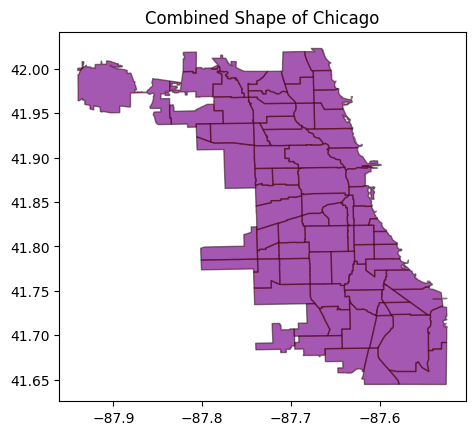

In [149]:
# Combine all the community areas into one shape (union of all geometries)
chicago_shape = unary_union(gdf['geometry'])

# Plot to visualize the combined shape
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k')
gpd.GeoSeries([chicago_shape]).plot(ax=ax, color='red', alpha=0.3)
plt.title('Combined Shape of Chicago')
plt.show()


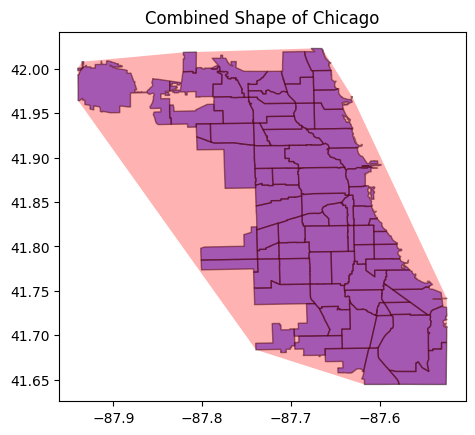

In [150]:
# Create the convex hull of the combined shape
chicago_shape_convex_hull = chicago_shape.convex_hull

# Plot to visualize the combined shape
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k')
gpd.GeoSeries([chicago_shape_convex_hull]).plot(ax=ax, color='red', alpha=0.3)
plt.title('Combined Shape of Chicago')
plt.show()

In [151]:
chicago_shape.geom_type

'MultiPolygon'

In [152]:
# Define the function to convert geometries to hexagons
def hexagonize_geodataframe(geometry, hex_size):
    """
    Convert a geometry to hexagons.
    
    Parameters:
    geometry (shapely.geometry): Input geometry to convert.
    hex_size (int): The hexagon size parameter for h3.
    
    Returns:
    GeoDataFrame: A GeoDataFrame with hexagonal cells.
    """
    hexagons = set()
    if isinstance(geometry, (Polygon, MultiPolygon)):
        # If it's a MultiPolygon, iterate over each Polygon
        if isinstance(geometry, MultiPolygon):
            geometries = geometry.geoms
        else:
            geometries = [geometry]
        
        for geom in geometries:
            if geom.is_empty:
                continue
            # Get the hexagons for the current geometry
            hexes = h3.polyfill(geom.__geo_interface__, hex_size, geo_json_conformant=True)
            hexagons.update(hexes)
    
    # Convert hexagons to GeoDataFrame
    hex_geometries = [h3.h3_to_geo_boundary(h, geo_json=True) for h in hexagons]
    hex_polygons = [Polygon(hex_geom) for hex_geom in hex_geometries]
    hex_gdf = gpd.GeoDataFrame(geometry=hex_polygons)
    
    return hex_gdf

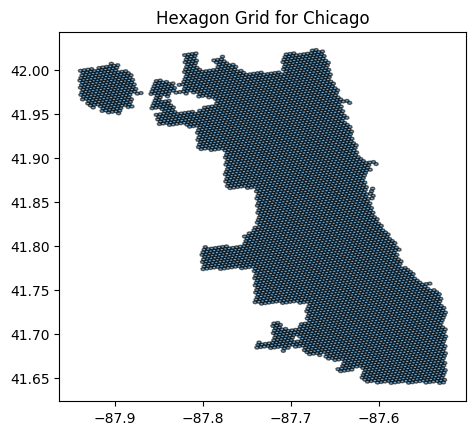

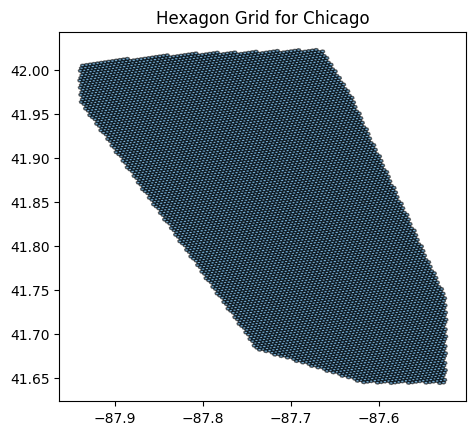

                                            geometry
0  POLYGON ((-87.76843 41.90893, -87.77025 41.907...
1  POLYGON ((-87.62950 41.82571, -87.63132 41.824...
2  POLYGON ((-87.82763 41.98491, -87.82944 41.983...
3  POLYGON ((-87.71097 41.79177, -87.71278 41.790...
4  POLYGON ((-87.71050 41.84921, -87.71231 41.848...


In [153]:
# Example usage for the entire city
hex_size = 9  # Example hexagon size
chicago_hex_gdf = hexagonize_geodataframe(chicago_shape, hex_size)
chicago_hex_gdf_convex_hull = hexagonize_geodataframe(chicago_shape_convex_hull, hex_size)

# Plot to visualize the hexagons
fig, ax = plt.subplots()
chicago_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.6)
plt.title('Hexagon Grid for Chicago')
plt.show()

# Plot to visualize the hexagons
fig, ax = plt.subplots()
chicago_hex_gdf_convex_hull.plot(ax=ax, edgecolor='k', alpha=0.6)
plt.title('Hexagon Grid for Chicago')
plt.show()

# Display the first few rows of the hexagon GeoDataFrame
print(chicago_hex_gdf.head())

In [154]:
# Function to assign hexagons to community areas
def assign_hexagons_to_areas(hex_gdf, areas_gdf):
    """
    Assign hexagons to community areas.
    
    Parameters:
    hex_gdf (GeoDataFrame): GeoDataFrame containing hexagons.
    areas_gdf (GeoDataFrame): GeoDataFrame containing community areas.
    
    Returns:
    GeoDataFrame: A GeoDataFrame with hexagons and their corresponding community area.
    """
    # Perform a spatial join to assign hexagons to community areas
    joined_gdf = gpd.sjoin(hex_gdf, areas_gdf, how='left')
    return joined_gdf

In [155]:
# Assign hexagons to community areas
assigned_hex_gdf = assign_hexagons_to_areas(chicago_hex_gdf, gdf)
assigned_hex_gdf_convex_hull = assign_hexagons_to_areas(chicago_hex_gdf_convex_hull, gdf)

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_26092/440296932.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf = gpd.sjoin(hex_gdf, areas_gdf, how='left')
/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_26092/440296932.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf = gpd.sjoin(hex_gdf, areas_gdf, how='left')


In [156]:
#Drop Duplicates
assigned_hex_gdf = assigned_hex_gdf.drop_duplicates(subset=['geometry'])
assigned_hex_gdf_convex_hull = assigned_hex_gdf_convex_hull.drop_duplicates(subset=['geometry'])

In [157]:
assigned_hex_gdf_convex_hull['community'].fillna('Outside Chicago', inplace=True)

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_26092/2140930817.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  assigned_hex_gdf_convex_hull['community'].fillna('Outside Chicago', inplace=True)


                                            geometry  index_right  \
0  POLYGON ((-87.76843 41.90893, -87.77025 41.907...           25   
1  POLYGON ((-87.62950 41.82571, -87.63132 41.824...            2   
2  POLYGON ((-87.82763 41.98491, -87.82944 41.983...           35   
3  POLYGON ((-87.71097 41.79177, -87.71278 41.790...           60   
4  POLYGON ((-87.71050 41.84921, -87.71231 41.848...           31   

        community area     shape_area perimeter area_num_1 area_numbe  \
0          AUSTIN    0  199254203.427         0         25         25   
1     FULLER PARK    0  19916704.8692         0         37         37   
2    NORWOOD PARK    0   121959105.47         0         10         10   
3       GAGE PARK    0  61284896.1132         0         63         63   
4  SOUTH LAWNDALE    0  127998297.867         0         30         30   

  comarea_id comarea      shape_len  
0          0       0  75226.4749167  
1          0       0  25339.0897503  
2          0       0  80368.3743

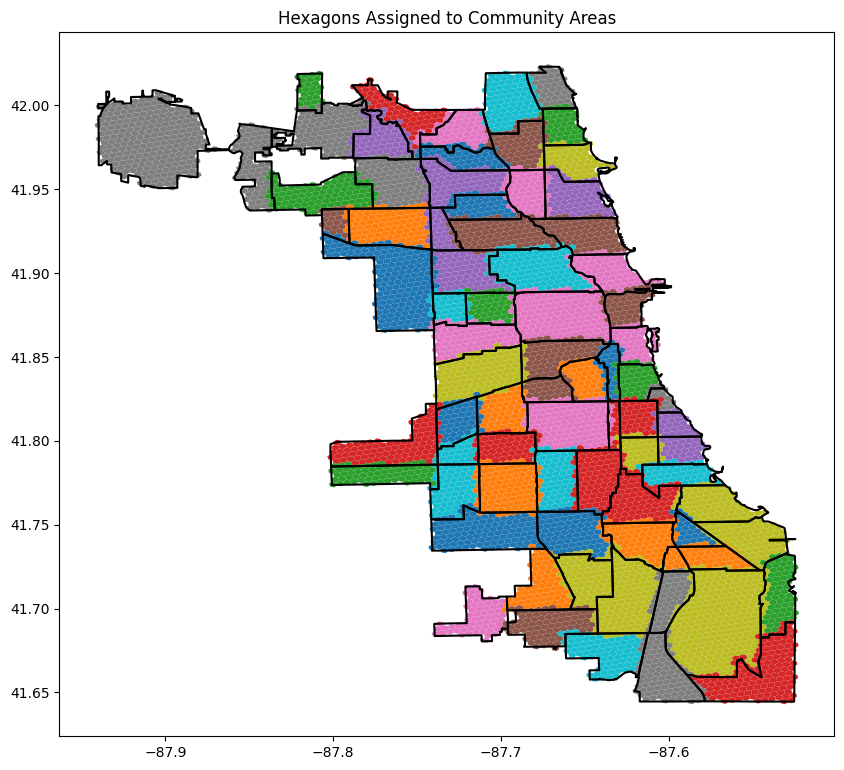

In [158]:
# Display the first few rows of the assigned hexagons GeoDataFrame
print(assigned_hex_gdf.head())

# Plot to visualize the hexagons with community areas
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, color='black')
assigned_hex_gdf.plot(ax=ax, column='community')
plt.title('Hexagons Assigned to Community Areas')
plt.show()

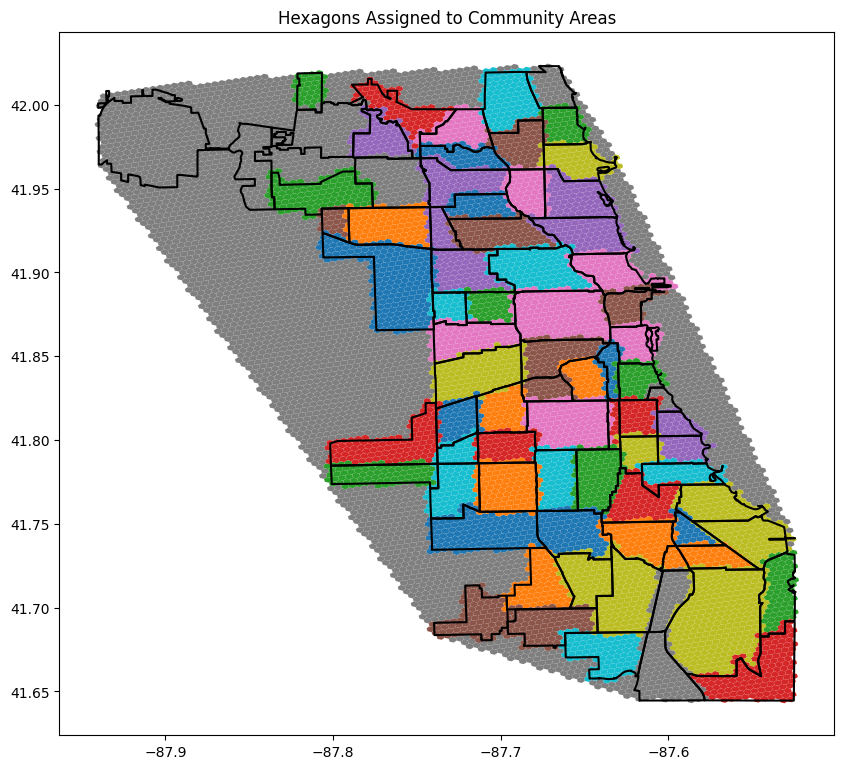

In [159]:
# Plot to visualize the hexagons with community areas
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, color='black')
assigned_hex_gdf_convex_hull.plot(ax=ax, column='community')
plt.title('Hexagons Assigned to Community Areas')
plt.show()

### Showcase of the top 5 farest rides

In [160]:
data = pd.read_pickle("../Datasets/taxi_trips_with_weather_cleaned.pkl")
data.head()

,trip_id,taxi_id,timestamp_start,timestamp_end,duration,distance,fare,tips,tolls,extras,...,dropoff_long,dropoff_location,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precipitation_rate,precipitation_accumulation
0,0cd46aa628ea5f871630113eb8ba92e4,09a6eaba341c43fc653756deff43a50f,2020-01-01,2020-01-01 00:15:00,180.0,0.64,4.50,0.00,0.0,1.0,...,-87.626211,POINT (-87.6262105324 41.8991556134),-2.83,-5.33,83.0,0.48,0.64,1.0088,0.0,0.0
1,4fbe84436a116f11c51ef3306e7adf0c,0f66b306ebea0f05dd124bf958729b64,2020-01-01,2020-01-01 00:30:00,1723.0,1.13,12.00,0.00,0.0,0.0,...,-87.626215,POINT (-87.6262149064 41.8925077809),-2.83,-5.33,83.0,0.48,0.64,1.0088,0.0,0.0
2,08a197de2703972bad8877628b18bb30,5a3410255ea0041b967e74090838b14d,2020-01-01,2020-01-01 00:00:00,420.0,0.97,6.00,0.00,0.0,1.0,...,-87.618868,POINT (-87.6188683546 41.8909220259),-2.83,-5.33,83.0,0.48,0.64,1.0088,0.0,0.0
3,94f8c8a4624a061988e0f32e12be04c5,3049f212da83687eb7ea5cb9d3046d89,2020-01-01,2020-01-01 00:30:00,1320.0,8.21,16.75,3.85,0.0,2.0,...,-87.676356,POINT (-87.6763559892 41.9012069941),-2.83,-5.33,83.0,0.48,0.64,1.0088,0.0,0.0
4,dd25d5229b1ce93ea03b7c9357e6f4f9,d9d9d16f34141de38105a060abd8a90c,2020-01-01,2020-01-01 00:15:00,504.0,1.19,6.25,0.00,0.0,1.0,...,-87.626215,POINT (-87.6262149064 41.8925077809),-2.83,-5.33,83.0,0.48,0.64,1.0088,0.0,0.0


In [161]:
TOP_5_Rides = data.nlargest(5, 'distance')

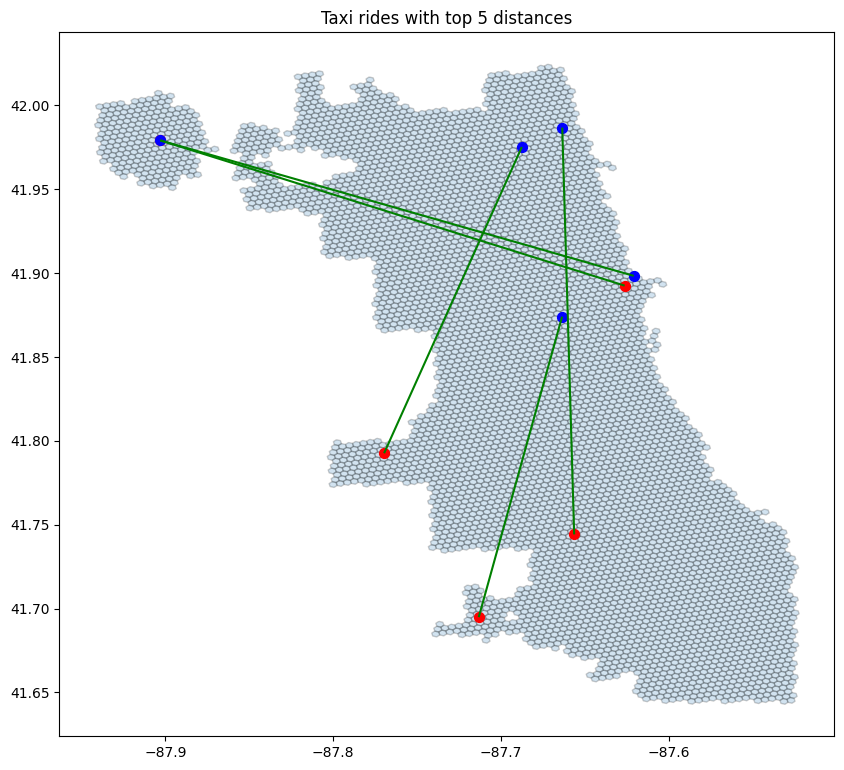

In [162]:
# Get coordinates of the start points and end points
start_points = TOP_5_Rides.apply(lambda row: Point(row['pickup_long'], row['pickup_lat']), axis=1)
end_points = TOP_5_Rides.apply(lambda row: Point(row['dropoff_long'], row['dropoff_lat']), axis=1)

# GDF
start_points_gdf = gpd.GeoDataFrame(geometry=start_points)
end_points_gdf = gpd.GeoDataFrame(geometry=end_points)

# Connect the start and end points with lines
lines = [LineString([start, end]) for start, end in zip(start_points, end_points)]
lines_gdf = gpd.GeoDataFrame(geometry=lines)

# Creat a plot
fig, ax = plt.subplots(figsize=(10, 10))
assigned_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.2)
start_points_gdf.plot(ax=ax, color='red', markersize=50)
end_points_gdf.plot(ax=ax, color='blue', markersize=50)
lines_gdf.plot(ax=ax, color='green')
plt.title('Taxi rides with top 5 distances')
plt.show()

Check if there are taxi rides that go beyond the existing community centers. Additionally, we will now consider whether it makes sense to create polygons at the city boundary if taxi rides also go there.

In [ ]:
# Get coordinates of the start points and end points
start_points = data.apply(lambda row: Point(row['pickup_long'], row['pickup_lat']), axis=1)
end_points = data.apply(lambda row: Point(row['dropoff_long'], row['dropoff_lat']), axis=1)

# GDF
start_points_gdf = gpd.GeoDataFrame(geometry=start_points)
end_points_gdf = gpd.GeoDataFrame(geometry=end_points)


# Creat a plot
fig, ax = plt.subplots(figsize=(15, 15))
assigned_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.2)
start_points_gdf.plot(ax=ax, color='red', markersize=20, alpha=0.2)
end_points_gdf.plot(ax=ax, color='blue', markersize=20, alpha=0.2)
plt.title('Taxi rides')
plt.show()

In [ ]:
# Get coordinates of the start points and end points
start_points = data.apply(lambda row: Point(row['pickup_long'], row['pickup_lat']), axis=1)
end_points = data.apply(lambda row: Point(row['dropoff_long'], row['dropoff_lat']), axis=1)

# GDF
start_points_gdf = gpd.GeoDataFrame(geometry=start_points)
end_points_gdf = gpd.GeoDataFrame(geometry=end_points)
# Test if the start points are outside the polygons
start_points_outside = start_points_gdf[~start_points_gdf.geometry.within(assigned_hex_gdf.unary_union)]

# Test if the end points are outside the polygons
end_points_outside = end_points_gdf[~end_points_gdf.geometry.within(assigned_hex_gdf.unary_union)]

# Ploting the points
fig, ax = plt.subplots(figsize=(10, 10))
assigned_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.6)
start_points_outside.plot(ax=ax, color='red', marker='o', label='Start Points Outside')
end_points_outside.plot(ax=ax, color='blue', marker='o', label='End Points Outside')
plt.legend()
plt.title('Start and End Points Outside Assigned Hexagons')
plt.show()

### Joining POIs to the hexagon map

In [163]:
# Read the GeoJSON file of the Chicago POIs
geojson_file = "../Datasets/POI.geojson"
POI_BIG = gpd.read_file(geojson_file)
POI_BIG.head()

,id,@id,access,addr:city,addr:country,addr:floor,addr:full,addr:housename,addr:housenumber,addr:place,...,website,website:menu,website:store,wheelchair,wheelchair:description,wifi,wikidata,wikipedia,yelp,geometry
0,node/271275603,node/271275603,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-87.62551 41.88481)
1,node/306741002,node/306741002,None,Chicago,None,None,None,None,600,None,...,None,None,None,yes,None,None,None,None,None,POINT (-87.60966 41.89141)
2,node/311438932,node/311438932,None,None,None,None,None,None,None,None,...,https://neofuturists.org/,None,None,None,None,None,Q16254317,en:Neo-Futurists,None,POINT (-87.66933 41.97579)
3,node/313107974,node/313107974,None,Chicago,None,None,None,None,700,None,...,https://www.imax.com/oo/navy-pier-imax/,None,None,None,None,None,Q37760649,None,None,POINT (-87.60924 41.89190)
4,node/318274065,node/318274065,None,Chicago,None,None,None,None,61,None,...,https://www.pizanoschicago.com/locations/chica...,None,None,None,None,None,None,None,None,POINT (-87.62567 41.88198)


In [164]:
POI = POI_BIG[['id', 'name', 'amenity', 'geometry']]
POI.head()

,id,name,amenity,geometry
0,node/271275603,Storefront Theater,theatre,POINT (-87.62551 41.88481)
1,node/306741002,Bubba Gump Shrimp Company,restaurant,POINT (-87.60966 41.89141)
2,node/311438932,Neofuturists,theatre,POINT (-87.66933 41.97579)
3,node/313107974,Navy Pier IMAX Theatre,cinema,POINT (-87.60924 41.89190)
4,node/318274065,Pizano's Pizza & Pasta,restaurant,POINT (-87.62567 41.88198)


In [165]:
POI.info()
POI.geometry

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4111 entries, 0 to 4110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        4111 non-null   object  
 1   name      4095 non-null   object  
 2   amenity   3862 non-null   object  
 3   geometry  4111 non-null   geometry
dtypes: geometry(1), object(3)
memory usage: 128.6+ KB


0       POINT (-87.62551 41.88481)
1       POINT (-87.60966 41.89141)
2       POINT (-87.66933 41.97579)
3       POINT (-87.60924 41.89190)
4       POINT (-87.62567 41.88198)
                   ...            
4106    POINT (-87.65999 41.97335)
4107    POINT (-87.68852 41.92507)
4108    POINT (-87.64110 41.79321)
4109    POINT (-87.62288 41.89308)
4110    POINT (-87.70452 41.92711)
Name: geometry, Length: 4111, dtype: geometry

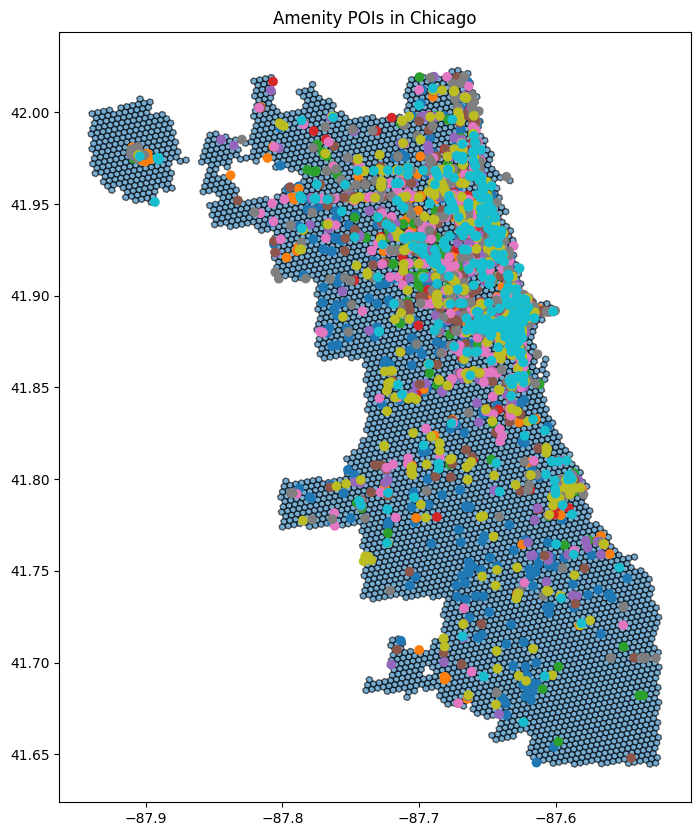

In [166]:
# Plot der POIs
fig, ax = plt.subplots(figsize=(10, 10))
assigned_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.6)
POI.plot(ax=ax, c=POI["amenity"], marker='o', cmap='tab10')
plt.title('Amenity POIs in Chicago')
plt.show()

In [167]:
print(POI["amenity"].unique())
POI
POI.info()

['theatre' 'restaurant' 'cinema' 'cafe' 'school' None 'university'
 'library' 'bar' 'clinic']
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4111 entries, 0 to 4110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        4111 non-null   object  
 1   name      4095 non-null   object  
 2   amenity   3862 non-null   object  
 3   geometry  4111 non-null   geometry
dtypes: geometry(1), object(3)
memory usage: 128.6+ KB


In [ ]:
POI

In [169]:
# Joining the POIs to the hexagons
assigned_hex_gdf.rename(columns={'index_right': 'assigned_index_right'}, inplace=True)
assigned_hex_gdf_poi = gpd.sjoin(assigned_hex_gdf, POI, how='left', op='intersects')
assigned_hex_gdf_poi

/Users/finnreinders/anaconda3/envs/AAA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_26092/1267277940.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  assigned_hex_gdf_poi = gpd.sjoin(assigned_hex_gdf, POI, how='left', op='intersects')


,geometry,assigned_index_right,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,index_right,id,name,amenity
0,"POLYGON ((-87.76843 41.90893, -87.77025 41.907...",25,AUSTIN,0,199254203.427,0,25,25,0,0,75226.4749167,NaN,NaN,NaN,NaN
1,"POLYGON ((-87.62950 41.82571, -87.63132 41.824...",2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,NaN,NaN,NaN,NaN
2,"POLYGON ((-87.82763 41.98491, -87.82944 41.983...",35,NORWOOD PARK,0,121959105.47,0,10,10,0,0,80368.3743778,NaN,NaN,NaN,NaN
3,"POLYGON ((-87.71097 41.79177, -87.71278 41.790...",60,GAGE PARK,0,61284896.1132,0,63,63,0,0,32294.1959107,NaN,NaN,NaN,NaN
4,"POLYGON ((-87.71050 41.84921, -87.71231 41.848...",31,SOUTH LAWNDALE,0,127998297.867,0,30,30,0,0,49904.0452102,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5624,"POLYGON ((-87.70446 41.77909, -87.70628 41.777...",63,CHICAGO LAWN,0,98279465.1151,0,66,66,0,0,40073.0998382,176.0,node/354234850,Magic Mirror Learning Center,school
5625,"POLYGON ((-87.71449 41.80218, -87.71630 41.801...",60,GAGE PARK,0,61284896.1132,0,63,63,0,0,32294.1959107,NaN,NaN,NaN,NaN
5626,"POLYGON ((-87.69240 41.85464, -87.69421 41.853...",31,SOUTH LAWNDALE,0,127998297.867,0,30,30,0,0,49904.0452102,NaN,NaN,NaN,NaN
5627,"POLYGON ((-87.55564 41.71106, -87.55745 41.709...",49,SOUTH DEERING,0,303797059.66,0,51,51,0,0,80389.8718002,NaN,NaN,NaN,NaN


In [170]:
"""
Von Data Wrangler generierte Zelle.
"""
def clean_data(assigned_hex_gdf_poi):
    # Ersetzen fehlender Werte durch "NO_AMENITY" in Spalte: 'amenity'
    assigned_hex_gdf_poi = assigned_hex_gdf_poi.fillna({'amenity': "NO_AMENITY"})
    # Gruppiert nach Spalten: 'geometry', 'community', 'amenity'
    assigned_hex_gdf_poi = assigned_hex_gdf_poi.groupby(['geometry', 'community', 'amenity']).count().reset_index()[['geometry', 'community', 'amenity']]
    return assigned_hex_gdf_poi

assigned_hex_gdf_poi_clean = clean_data(assigned_hex_gdf_poi.copy())
assigned_hex_gdf_poi_clean.head()

,geometry,community,amenity
0,"POLYGON ((-87.73941 41.68656, -87.74122 41.685...",MOUNT GREENWOOD,NO_AMENITY
1,"POLYGON ((-87.73521 41.68718, -87.73702 41.686...",MOUNT GREENWOOD,NO_AMENITY
2,"POLYGON ((-87.73819 41.68947, -87.74000 41.688...",MOUNT GREENWOOD,NO_AMENITY
3,"POLYGON ((-87.73399 41.69009, -87.73579 41.688...",MOUNT GREENWOOD,NO_AMENITY
4,"POLYGON ((-87.73697 41.69238, -87.73877 41.691...",MOUNT GREENWOOD,NO_AMENITY


In [196]:
df = assigned_hex_gdf_poi_clean.pivot_table(index=['geometry', 'community'], 
                                            values='amenity', 
                                            columns='amenity', 
                                            aggfunc='size', 
                                            fill_value=0)
df

,amenity,NO_AMENITY,bar,cafe,cinema,clinic,library,restaurant,school,theatre,university
geometry,community,,,,,,,,,,
"POLYGON ((-87.73941 41.68656, -87.74122 41.685...",MOUNT GREENWOOD,1,0,0,0,0,0,0,0,0,0
"POLYGON ((-87.73521 41.68718, -87.73702 41.686...",MOUNT GREENWOOD,1,0,0,0,0,0,0,0,0,0
"POLYGON ((-87.73819 41.68947, -87.74000 41.688...",MOUNT GREENWOOD,1,0,0,0,0,0,0,0,0,0
"POLYGON ((-87.73399 41.69009, -87.73579 41.688...",MOUNT GREENWOOD,1,0,0,0,0,0,0,0,0,0
"POLYGON ((-87.73697 41.69238, -87.73877 41.691...",MOUNT GREENWOOD,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
"POLYGON ((-87.53182 41.64641, -87.53363 41.645...",HEGEWISCH,1,0,0,0,0,0,0,0,0,0
"POLYGON ((-87.53058 41.64931, -87.53240 41.648...",HEGEWISCH,1,0,0,0,0,0,0,0,0,0
"POLYGON ((-87.52935 41.65222, -87.53116 41.651...",HEGEWISCH,1,0,0,0,0,0,0,0,0,0


Creating Time Dataframe

In [ ]:
def generate_time_series(start_time, end_time, freq_minutes):
    """
    Generate a time series with additional features.
    
    Parameters:
    start_time (str): The start time in 'YYYY-MM-DD HH:MM:SS' format.
    end_time (str): The end time in 'YYYY-MM-DD HH:MM:SS' format.
    freq_minutes (int): Frequency of the time series in minutes.
    
    Returns:
    DataFrame: A DataFrame containing the time series and additional features.
    """
    # Create the time series
    time_series = pd.date_range(start=start_time, end=end_time, freq=f'{freq_minutes}T')
    df = pd.DataFrame(time_series, columns=['datetime'])
    
    # Extract additional features
    df['weekday'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week
    df['quarter'] = df['datetime'].dt.quarter
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df['hour'] = df['datetime'].dt.hour
    df['is_month_start'] = df['datetime'].dt.is_month_start
    df['is_month_end'] = df['datetime'].dt.is_month_end
    df['is_quarter_start'] = df['datetime'].dt.is_quarter_start
    df['is_quarter_end'] = df['datetime'].dt.is_quarter_end
    df['is_year_start'] = df['datetime'].dt.is_year_start
    df['is_year_end'] = df['datetime'].dt.is_year_end
    df['is_leap_year'] = df['datetime'].dt.is_leap_year
    
    # Define time of day segments
    def get_time_of_day(hour):
        if hour >= 5 and hour < 12:
            return 'morning'
        elif hour >= 12 and hour < 17:
            return 'afternoon'
        elif hour >= 17 and hour < 21:
            return 'evening'
        else:
            return 'night'
    
    df['time_of_day'] = df['hour'].apply(get_time_of_day)
    
    
    return df

# Example usage
start_time = '2020-01-01 00:00:00'
end_time = '2021-01-01 00:00:00'
freq_minutes = 5

time_series_df = generate_time_series(start_time, end_time, freq_minutes)
time_series_df.head()